In [1]:
%cd /content/drive/MyDrive/ColabWork/PyTorchSegmentation

/content/drive/MyDrive/ColabWork/PyTorchSegmentation


In [2]:
'''
!wget --quiet http://sceneparsing.csail.mit.edu/data/ChallengeData2017/images.tar
!wget --quiet http://sceneparsing.csail.mit.edu/data/ChallengeData2017/annotations_instance.tar
!tar -xf images.tar
!tar -xf annotations_instance.tar
!rm images.tar annotations_instance.tar
!pip install -qU torch_snippets
!wget --quiet https://raw.githubusercontent.com/pytorch/vision/master/references/detection/engine.py
!wget --quiet https://raw.githubusercontent.com/pytorch/vision/master/references/detection/utils.py
!wget --quiet https://raw.githubusercontent.com/pytorch/vision/master/references/detection/transforms.py
!wget --quiet https://raw.githubusercontent.com/pytorch/vision/master/references/detection/coco_eval.py
!wget --quiet https://raw.githubusercontent.com/pytorch/vision/master/references/detection/coco_utils.py
!pip install -q -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
'''

"\n!wget --quiet http://sceneparsing.csail.mit.edu/data/ChallengeData2017/images.tar\n!wget --quiet http://sceneparsing.csail.mit.edu/data/ChallengeData2017/annotations_instance.tar\n!tar -xf images.tar\n!tar -xf annotations_instance.tar\n!rm images.tar annotations_instance.tar\n!pip install -qU torch_snippets\n!wget --quiet https://raw.githubusercontent.com/pytorch/vision/master/references/detection/engine.py\n!wget --quiet https://raw.githubusercontent.com/pytorch/vision/master/references/detection/utils.py\n!wget --quiet https://raw.githubusercontent.com/pytorch/vision/master/references/detection/transforms.py\n!wget --quiet https://raw.githubusercontent.com/pytorch/vision/master/references/detection/coco_eval.py\n!wget --quiet https://raw.githubusercontent.com/pytorch/vision/master/references/detection/coco_utils.py\n!pip install -q -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'\n"

In [3]:
!pip install -qU torch_snippets
!pip install -q -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'


In [4]:
from torch_snippets import *
import sklearn
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

from engine import train_one_epoch, evaluate
import utils
import transforms as T
device = 'cuda' if torch.cuda.is_available() else 'cpu'


[04/07/21 17:31:01] WARNING  Not importing Lightning Report      ]8;id=1617816661.0798573-224115;file:///usr/local/lib/python3.7/dist-packages/torch_snippets/torch_loader.py\torch_loader.py]8;;\:<module>:233

                    WARNING  sklearn is not found. Skipping relevant  ]8;id=1617816661.364487-814473;file:///usr/local/lib/python3.7/dist-packages/torch_snippets/__init__.py\__init__.py]8;;\:<module>:13
                             imports from submodule `sklegos`

In [5]:
all_images = Glob('images/training')
all_annots = Glob('annotations_instance/training')

                    INFO     20210 files found at   ]8;id=1617816661.6328425-787132;file://<ipython-input-5-b014b7bc9b6c>\<ipython-input-5-b014b7bc9b6c>]8;;\:<module>:1
                             images/training

                    INFO     20210 files found at a ]8;id=1617816661.8536422-62525;file://<ipython-input-5-b014b7bc9b6c>\<ipython-input-5-b014b7bc9b6c>]8;;\:<module>:2
                             nnotations_instance/tr                                          
                             aining

In [6]:
#find??

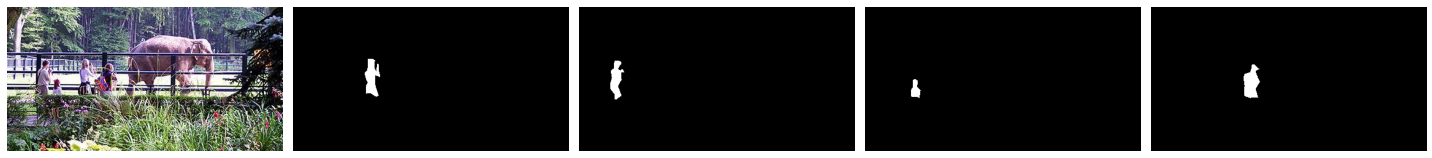

In [7]:
f = 'ADE_train_00014301'
f = 'ADE_train_00020204'

im = read(find(f, all_images), 1)
an = read(find(f, all_annots), 1).transpose(2,0,1)
r,g,b = an
nzs = np.nonzero(r==4) # 4 stands for person
instances = np.unique(g[nzs])
masks = np.zeros((len(instances), *r.shape))
for ix,_id in enumerate(instances):
    masks[ix] = g==_id

subplots([im, *masks], sz=20)

In [8]:
an.shape

(3, 236, 450)

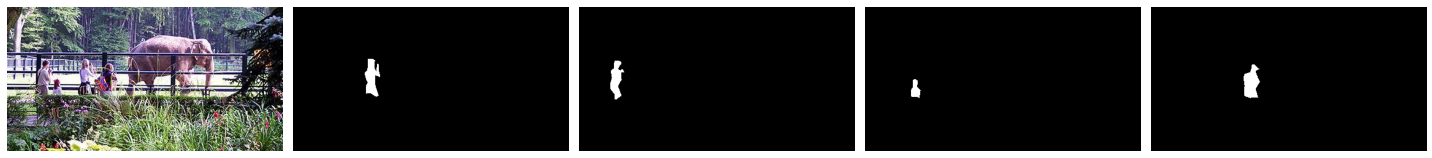

In [9]:
im = read(find(f, all_images), 1)
an = read(find(f, all_annots), 1).transpose(2,0,1)
r,g,b = an
nzs = np.nonzero(r==4) # 4 stands for person
instances = np.unique(g[nzs])
masks = np.zeros((len(instances), *r.shape))
for ix,_id in enumerate(instances):
    masks[ix] = g==_id

subplots([im, *masks], sz=20)

In [10]:
nzs[0].shape,nzs[1].shape

((3078,), (3078,))

In [11]:
r.mean(),r.min(),r.max()

(0.6732203389830509, 0, 16)

In [12]:
Tqdm??

In [13]:
_ann=None

In [14]:
annots = []
for ann in Tqdm(all_annots,):
    _ann = read(ann, 1).transpose(2,0,1)
    r,g,b = _ann
    if 4 not in np.unique(r): continue
    annots.append(ann)

100%|██████████| 20210/20210 [2:26:50<00:00,  2.29it/s]


In [15]:
from sklearn.model_selection import train_test_split
_annots = stems(annots)
trn_items, val_items = train_test_split(_annots, random_state=2)

In [16]:
#stem??

In [17]:
#_annots

In [18]:
def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)


In [19]:
class MasksDataset(Dataset):

    def __init__(self, items, transforms, N):
        self.items = items
        self.transforms = transforms
        self.N = N
    def get_mask(self, path):
        an = read(path, 1).transpose(2,0,1)
        r,g,b = an
        nzs = np.nonzero(r==4)
        instances = np.unique(g[nzs])
        masks = np.zeros((len(instances), *r.shape))
        for ix,_id in enumerate(instances):
            masks[ix] = g==_id
        return masks
    def __getitem__(self, ix):
        _id = self.items[ix]
        img_path = f'images/training/{_id}.jpg'
        mask_path = f'annotations_instance/training/{_id}.png'
        masks = self.get_mask(mask_path)
        obj_ids = np.arange(1, len(masks)+1)
        img = Image.open(img_path).convert("RGB")
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            obj_pixels = np.where(masks[i])
            xmin = np.min(obj_pixels[1])
            xmax = np.max(obj_pixels[1])
            ymin = np.min(obj_pixels[0])
            ymax = np.max(obj_pixels[0])
            if (((xmax-xmin)<=10) | (ymax-ymin)<=10):
                xmax = xmin+10
                ymax = ymin+10
            boxes.append([xmin, ymin, xmax, ymax])
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)
        image_id = torch.tensor([ix])
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd
        if self.transforms is not None:
            img, target = self.transforms(img, target)
        return img, target
    def __len__(self):
        return self.N
    def choose(self):
        return self[randint(len(self))]

==================================================================

Tensor  Shape: torch.Size([3, 512, 683])        Min: 0.000      Max: 1.000      Mean: 0.495  
dtype: torch.float32

==================================================================

Dict Of 6 items

==================================================================

BOXES:
        Tensor  Shape: torch.Size([1, 4])       Min: 65.000     Max: 612.000    Mean: 361.750
dtype: torch.float32

==================================================================

==================================================================

LABELS:
        Tensor  Shape: torch.Size([1])  Min: 1.000      Max: 1.000      Mean: 1.000     
dtype: torch.int64

==================================================================

==================================================================

MASKS:
        Tensor  Shape: torch.Size([1, 512, 683])        Min: 0.000      Max: 1.000      Mean:
0.152     dtype: torch.uint8

==================================================================

==================================================================

IMAGE_ID:
        Tensor  Shape: torch.Size([1])  Min: 0.000      Max: 0.000      Mean: 0.000     
dtype: torch.int64

==================================================================

==================================================================

AREA:
        Tensor  Shape: torch.Size([1])  Min: 157438.000 Max: 157438.000 Mean: 157438.000     
dtype: torch.float32

==================================================================

... ... 1 more items

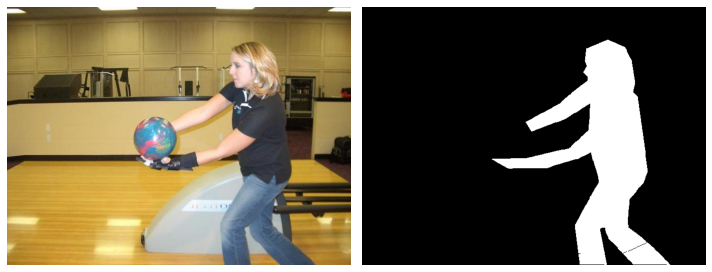

In [20]:
x = MasksDataset(trn_items, get_transform(train=True), N=100)
im,targ = x[0]
inspect(im,targ)
subplots([im, *targ['masks']], sz=10)


In [21]:
def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,num_classes)
    return model

In [22]:
model = get_model_instance_segmentation(2).to(device)
model


Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

In [23]:
dataset = MasksDataset(trn_items, get_transform(train=True), N=3000)
dataset_test = MasksDataset(val_items, get_transform(train=False), N=800)

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=0,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=0,
    collate_fn=utils.collate_fn)

In [24]:
num_classes = 2
model = get_model_instance_segmentation(num_classes).to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)
# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                step_size=3,
                                                gamma=0.1)


In [25]:
num_epochs = 10

trn_history = []
for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    res = train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    trn_history.append(res)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    res = evaluate(model, data_loader_test, device=device)


Epoch: [0]  [   0/1500]  eta: 0:44:16  lr: 0.000010  loss: 3.5697 (3.5697)  loss_classifier: 0.7448 (0.7448)  loss_box_reg: 0.3080 (0.3080)  loss_mask: 2.4222 (2.4222)  loss_objectness: 0.0788 (0.0788)  loss_rpn_box_reg: 0.0158 (0.0158)  time: 1.7712  data: 1.2177  max mem: 2309
Epoch: [0]  [  10/1500]  eta: 0:35:08  lr: 0.000060  loss: 3.5082 (3.4575)  loss_classifier: 0.7670 (0.7563)  loss_box_reg: 0.3080 (0.3062)  loss_mask: 2.3923 (2.2904)  loss_objectness: 0.0679 (0.0674)  loss_rpn_box_reg: 0.0245 (0.0372)  time: 1.4148  data: 1.0367  max mem: 3556
Epoch: [0]  [  20/1500]  eta: 0:34:54  lr: 0.000110  loss: 2.3417 (2.6285)  loss_classifier: 0.6001 (0.6096)  loss_box_reg: 0.3119 (0.3151)  loss_mask: 1.3568 (1.5970)  loss_objectness: 0.0325 (0.0729)  loss_rpn_box_reg: 0.0213 (0.0340)  time: 1.3977  data: 1.0311  max mem: 3559
Epoch: [0]  [  30/1500]  eta: 0:33:59  lr: 0.000160  loss: 1.3588 (2.1411)  loss_classifier: 0.3396 (0.4959)  loss_box_reg: 0.2750 (0.3125)  loss_mask: 0.6059 (

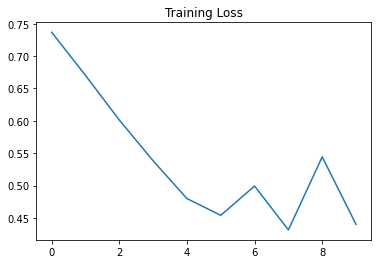

In [26]:
import matplotlib.pyplot as plt
plt.title('Training Loss')
losses = [np.mean(list(trn_history[i].meters['loss'].deque)) for i in range(len(trn_history))]
plt.plot(losses)

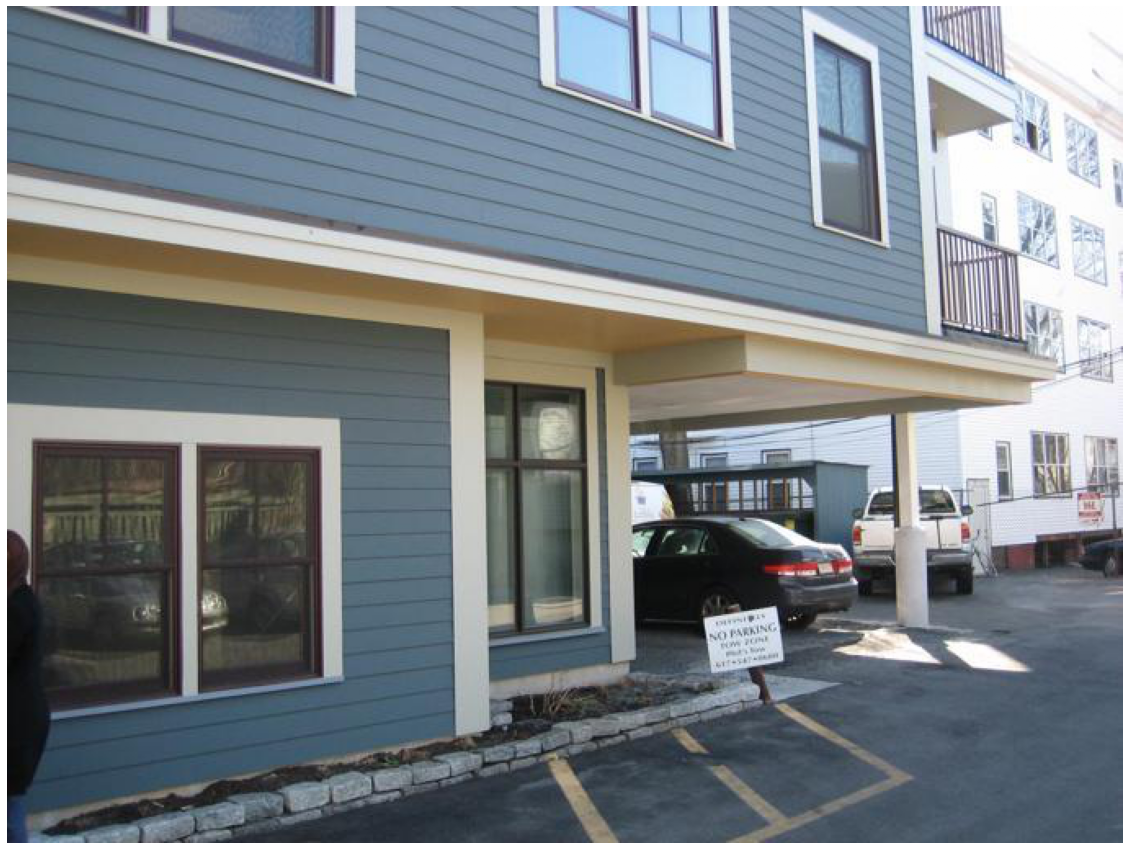

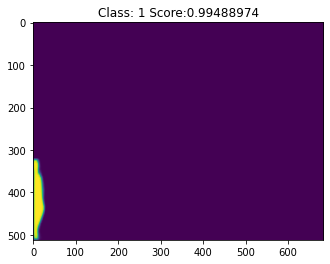

In [27]:
model.eval()
im = dataset_test[0][0]
show(im)
with torch.no_grad():
    prediction = model([im.to(device)])
    for i in range(len(prediction[0]['masks'])):
        plt.imshow(Image.fromarray(prediction[0]['masks'][i, 0].mul(255).byte().cpu().numpy()))
        plt.title('Class: '+str(prediction[0]['labels'][i].cpu().numpy())+' Score:'+str(prediction[0]['scores'][i].cpu().numpy()))
        plt.show()

In [28]:
model.save('first-run.pkl')

AttributeError: ignored